In [1]:
import os
import time
import math
import copy
import json
import logging

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

%matplotlib inline

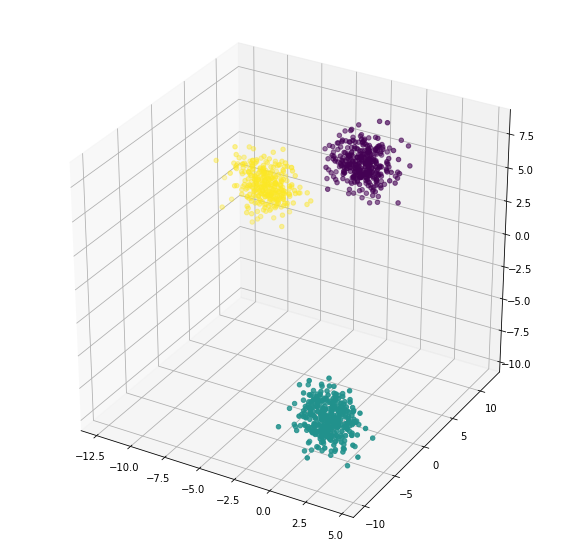

In [3]:
XX, yyy = make_blobs(2000, n_features=3, random_state=42)


X = XX[0:1000]
yy = yyy[0:1000]

X_test = XX[1000:]
yy_test = yyy[1000:]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=yy)


# convert to pytorch tensors
X = torch.FloatTensor(X)
y = torch.zeros(X.size(0), 3)
for idx, _ in enumerate(yy):
    y[idx, _] = 1.0

X_test = torch.FloatTensor(X_test)
   
y_test = torch.zeros(X_test.size(0), 3)
for idx, _ in enumerate(yy_test):
    y_test[idx, _] = 1.0

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 3),
            nn.ReLU(True),
            nn.Linear(3, 3)
        )
    
    def forward(self, x):
        return self.layers(x)

    def compute_loss(self, x, y):
        out = self(x)
        return F.binary_cross_entropy_with_logits(out, y)


### Train a network until it learns to predict all ones for the output

In [5]:
def sem_loss(probs):
    s = torch.zeros(1)
    
    for i, p_i in enumerate(probs):
        s_part = p_i
        for j, p_j in enumerate(probs):
            if i == j:
                continue
            s_part = torch.mul(s_part, (1 - p_j))
        s += s_part
    return -1 * torch.log(s)

In [6]:
np.random.seed(42)
torch.manual_seed(42)

net = Net()

opt = optim.Adam(net.parameters())
for i in range(3000):    
    opt.zero_grad()
    loss = net.compute_loss(X, torch.ones(X.size(0), 3))
    loss.backward()
    opt.step()
#     print(loss.item())
    
    with torch.no_grad():
        
        y_pred = torch.sigmoid(net(X))
        # accuracy_score(yy, y_pred.detach().numpy().argmax(1))
        y_pred[y_pred > 0.5] = 1
        all_ones = (y_pred == 1.0).view(-1).sum()
#         print(all_ones)
        if all_ones == np.prod(y_pred.shape):
            break

print("All ones: DONE!")            
### Now train only with the semantic loss and note the number of constraints it satisfies 
opt = optim.Adam(net.parameters(), lr=0.01)
loss_ot = []
sat_ot = []
for i in range(100):    
    opt.zero_grad()
    out = net(X)
    batch_loss = torch.zeros(X.size(0))
    for i, o in enumerate(out):
        batch_loss[i] = sem_loss(torch.sigmoid(o))
    loss = batch_loss.mean()
    loss.backward()
    opt.step()

    loss_ot.append(loss.item())
    
    
    with torch.no_grad():
        y_pred = torch.sigmoid(net(X))
        logits = copy.deepcopy(y_pred)
        logits[logits > 0.5] = 1
        logits[logits <= 0.5] = 0
        sat = logits.sum(dim=1)
        sat = (sat == 1).sum()
        sat_ot.append(sat)
        print(sat, loss.item())
#         if sat == X.size(0):
                    

All ones: DONE!
tensor(0) 2.952587127685547
tensor(0) 2.776423692703247
tensor(0) 2.611624002456665
tensor(0) 2.458329677581787
tensor(0) 2.3160877227783203
tensor(0) 2.184173822402954
tensor(0) 2.0619778633117676
tensor(0) 1.9489762783050537
tensor(0) 1.8445531129837036
tensor(0) 1.7480207681655884
tensor(0) 1.6589642763137817
tensor(0) 1.5768227577209473
tensor(1) 1.5011385679244995
tensor(9) 1.4314870834350586
tensor(48) 1.367394208908081
tensor(125) 1.3083512783050537
tensor(227) 1.2538973093032837
tensor(306) 1.2035998106002808
tensor(345) 1.1570279598236084
tensor(399) 1.1137431859970093
tensor(510) 1.0733181238174438
tensor(624) 1.0353156328201294
tensor(673) 0.9992255568504333
tensor(686) 0.9645546078681946
tensor(703) 0.9308790564537048
tensor(731) 0.8978963494300842
tensor(759) 0.8652868270874023
tensor(785) 0.832659900188446
tensor(829) 0.8000270128250122
tensor(859) 0.7673029899597168
tensor(886) 0.734456479549408
tensor(912) 0.7016273736953735
tensor(932) 0.668989777565002

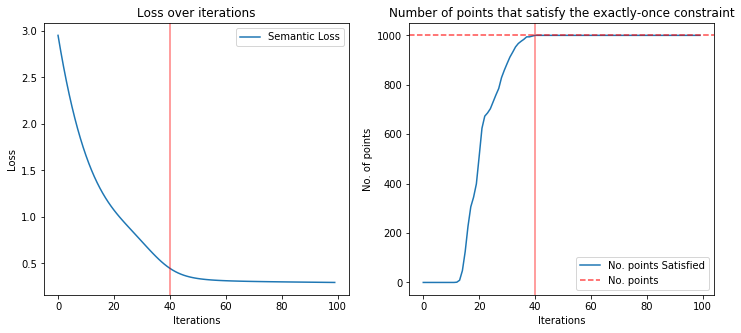

In [7]:
fig = plt.figure(figsize=(12, 5))

# first position at which # of points == 1000
sat_pos = sat_ot.index(1000)

ax = fig.add_subplot(121)
ax.plot(loss_ot, label="Semantic Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)


ax = fig.add_subplot(122)
ax.plot(sat_ot, label="No. points Satisfied")
ax.axhline(1000, 0, len(sat_ot), label="No. points", linestyle="--", color="red", alpha=0.7)
ax.axvline(sat_pos, 0, 1000, linestyle="-", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("No. of points")
ax.set_title("Number of points that satisfy the exactly-once constraint")

plt.savefig("./gaussian_blobs.png", dpi=300)

## Experiment 2

TODO Description

In [6]:
def experiment(net_fn, n_points = 1000, n_test=200, learning_rate=0.1, random_seed=2):
    
    def run_experiment(percent_data, w, n_iter=100, val_percent = 0.1):
        assert percent_data + val_percent <= 1.0 
        n_train = int(percent_data * X.size(0))
        n_val = int(val_percent * X.size(0))
        rand_idx = np.random.permutation(np.arange(X.size(0)))
        train_idx = rand_idx[:n_train]
        val_idx = rand_idx[n_train: n_train + n_val]
        
        X_train = X[train_idx]
        y_train = y[train_idx]
        
        X_val = X[val_idx]
        y_val = y[val_idx]
        
        net = net_fn()
        opt = optim.Adam(net.parameters())
        
        best_val_wts = net.state_dict()
        best_val_acc = float("-inf")
        
        for i in range(n_iter):
            net.train()
            opt.zero_grad()
            
            out = net(X_train)
            bce = F.binary_cross_entropy_with_logits(out, y_train)
            batch_loss = torch.zeros(X_train.size(0))
            for i, o in enumerate(out):
                batch_loss[i] = sem_loss(torch.sigmoid(o))
            sl = w * batch_loss.mean()
            loss = bce + sl
            loss.backward()
            opt.step()
            
            # compute val accuracy
            with torch.no_grad():
                net.eval()
                out = torch.sigmoid(net(X_val))
                correct = (out.argmax(dim=1) == y_val.argmax(dim=1)).sum()
                accuracy = float(correct) / X_val.size(0)

                if accuracy > best_val_acc:
                    best_val_acc = accuracy
                    best_val_wts = net.state_dict()
        
        # load with best model
        net.load_state_dict(best_val_wts)
            
        net.eval()
        with torch.no_grad():
            out = torch.sigmoid(net(X_test))
            correct = (out.argmax(dim=1) == y_test.argmax(dim=1)).sum()
            accuracy = float(correct) / X_test.size(0)
        
        print("N points: {}, w:{}, Best Val Accuracy: {}, Accuracy: {}".format(n_train, w, best_val_acc, accuracy))
            
        return {"accuracy": accuracy}
        
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    XX, yyy = make_blobs(n_points, n_features=3, random_state=random_seed)


    X = XX[:n_points - n_test]
    yy = yyy[:n_points - n_test]

    X_test = XX[n_points - n_test:]
    yy_test = yyy[n_points - n_test:]

    X = torch.FloatTensor(X)
    X_test = torch.FloatTensor(X_test)

    y = torch.zeros(X.size(0), 3)
    for idx, _ in enumerate(yy):
        y[idx, _] = 1.0

    y_test = torch.zeros(X_test.size(0), 3)
    for idx, _ in enumerate(yy_test):
        y_test[idx, _] = 1.0

    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.1, c=y)
    ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
    ax.view_init(elev=10, azim=45)
    ax.grid(False)
    
    plt.savefig("gauss_exp2.png")
    plt.close()
    
    w_choices = [0, 1, 2]
    percent_data = [0.1, 0.25, 0.5, 0.75, 0.9]
    experiments = []
    
    for w in w_choices:
        for p in percent_data:
            experiments.append({
                "percent_data": p,
                "w": w
            })
    
    results = []
    for experiment in experiments:
        results.append({
            "params": experiment,
            "results": run_experiment(experiment["percent_data"], experiment["w"])
        })
    
    with open("./gauss_blobs_results.json", "w") as writer:
        writer.write(json.dumps(results, indent=1))
    
    

    # convert to pytorch tensors
    
    
    
experiment(Net, random_seed=2)

N points: 80, w:0, Best Val Accuracy: 0.6875, Accuracy: 0.63
N points: 200, w:0, Best Val Accuracy: 0.325, Accuracy: 0.31
N points: 400, w:0, Best Val Accuracy: 0.3375, Accuracy: 0.405
N points: 600, w:0, Best Val Accuracy: 0.2875, Accuracy: 0.24
N points: 720, w:0, Best Val Accuracy: 0.6125, Accuracy: 0.575
N points: 80, w:1, Best Val Accuracy: 0.3, Accuracy: 0.3
N points: 200, w:1, Best Val Accuracy: 0.6625, Accuracy: 0.74
N points: 400, w:1, Best Val Accuracy: 0.525, Accuracy: 0.365
N points: 600, w:1, Best Val Accuracy: 0.0, Accuracy: 0.0
N points: 720, w:1, Best Val Accuracy: 0.6375, Accuracy: 0.72
N points: 80, w:2, Best Val Accuracy: 0.4125, Accuracy: 0.34
N points: 200, w:2, Best Val Accuracy: 0.4875, Accuracy: 0.365
N points: 400, w:2, Best Val Accuracy: 0.3125, Accuracy: 0.355
N points: 600, w:2, Best Val Accuracy: 0.025, Accuracy: 0.03
N points: 720, w:2, Best Val Accuracy: 0.6125, Accuracy: 0.555
